# Optimizing Inventory and Pricing Strategies for Zepto
**Project by Vivek Balmiki**

This notebook details the analysis of inventory and pricing strategies for the quick-commerce platform Zepto. The goal of this project is to use a public dataset to identify the root causes of two major business challenges: frequent stockouts of essential items and sub-optimal pricing. The final output is a set of data-driven, actionable recommendations to help Zepto improve its operational efficiency and profitability.

***
## 1. Setup and Data Loading
First, we'll import the necessary Python libraries for data manipulation and visualization, and then load our dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('./dataset/zepto.csv', encoding='windows-1252')

print("Dataset loaded successfully.")

Dataset loaded successfully.


## 2. Data Cleaning and Preprocessing
A preliminary review of the dataset indicates a high level of quality. All 3,732 rows are complete, with no missing values.

The main preprocessing step involves the pricing columns (`mrp` and `discountedSellingPrice`). The values are stored as integers representing the price in paisa (e.g., a value of 15700 represents ₹157.00). To make the analysis easier to interpret, we will convert these columns to their actual values in Indian Rupees (₹) by dividing by 100.

In [2]:
# Scale the pricing columns from paisa to rupees
df['mrp'] = df['mrp'] / 100
df['discountedSellingPrice'] = df['discountedSellingPrice'] / 100

print("Pricing columns have been scaled to Rupees.")
print("Displaying the first 5 rows of the cleaned data:")
df.head()

Pricing columns have been scaled to Rupees.
Displaying the first 5 rows of the cleaned data:


,Category,name,mrp,discountPercent,availableQuantity,discountedSellingPrice,weightInGms,outOfStock,quantity
0,Fruits & Vegetables,Onion,25.0,16,3,21.0,1000,False,1
1,Fruits & Vegetables,Tomato Hybrid,42.0,16,3,35.0,1000,False,1
2,Fruits & Vegetables,Tender Coconut,51.0,15,3,43.0,58,False,1
3,Fruits & Vegetables,Coriander Leaves,20.0,15,3,17.0,100,False,100
4,Fruits & Vegetables,Ladies Finger,14.0,14,3,12.0,250,False,250


## 3. Descriptive Statistics & Initial Insights
Now, let's perform an initial exploratory data analysis to get a high-level understanding of the business.

### Stock Availability
The first key metric is to understand the scale of the stockout problem.

C:\Users\balmi\AppData\Local\Temp\ipykernel_2728\1922104158.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outOfStock', data=df, palette='pastel')


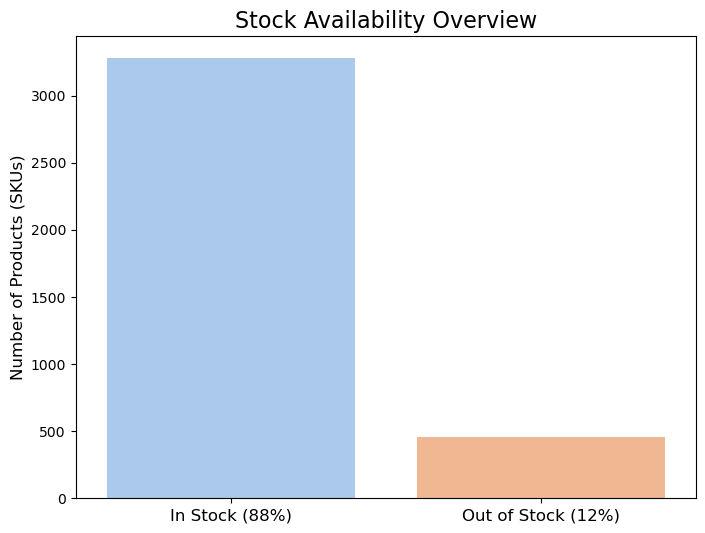

In [3]:
# --- Visualization: Stock Availability Overview ---
plt.figure(figsize=(8, 6))
sns.countplot(x='outOfStock', data=df, palette='pastel')
plt.title('Stock Availability Overview', fontsize=16)
plt.ylabel('Number of Products (SKUs)', fontsize=12)
plt.xlabel('')
plt.xticks([0, 1], ['In Stock (88%)', 'Out of Stock (12%)'], fontsize=12)
plt.show()

The chart above confirms a **significant stockout rate of 12.14%**, affecting a substantial portion of the product catalog.

### Product Portfolio
Next, let's look at the distribution of products across different categories.

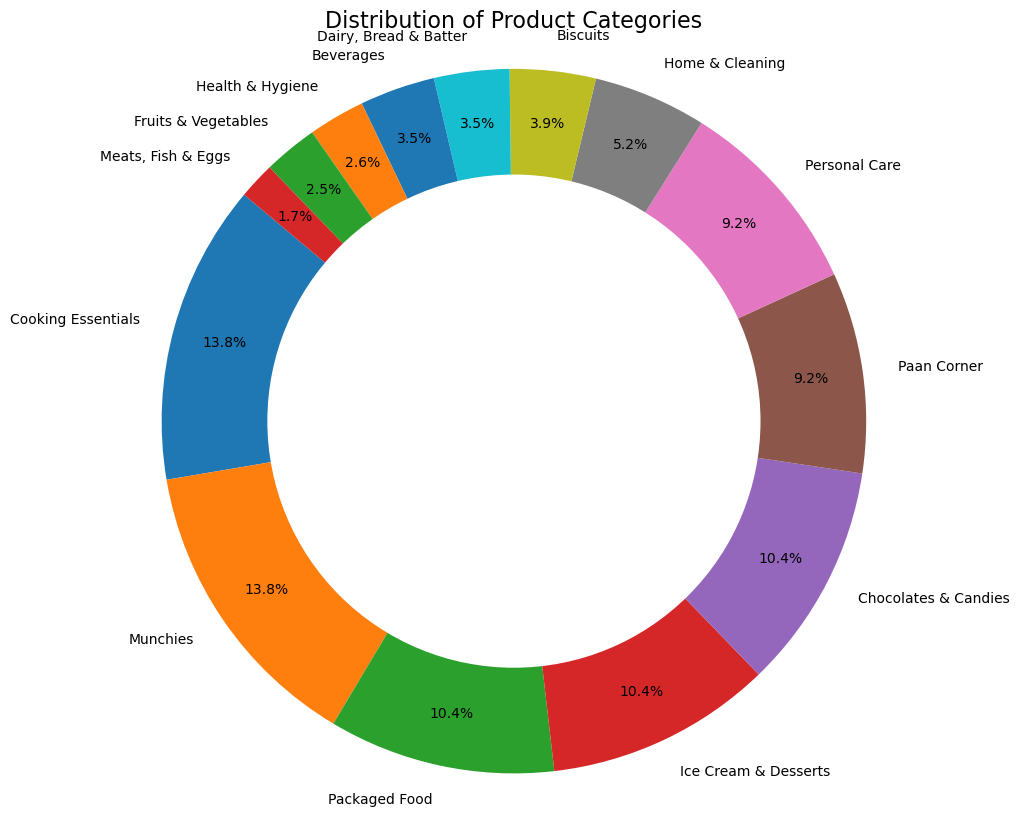

In [4]:
# --- Visualization: Product Category Distribution ---
plt.figure(figsize=(10, 10))
category_counts = df['Category'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.title('Distribution of Product Categories', fontsize=16)
# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

The product mix is diverse, with 14 unique categories. The largest segments are **"Cooking Essentials"** and **"Munchies"**, each making up 14% of the catalog. This helps us know where to focus our inventory analysis.

***
## 4. Deeper Analysis: Inventory Risk (ABC Classification)
To move beyond a simple overview and formally prioritize inventory management efforts, we will perform an **ABC Analysis**. We'll classify each category into A (High Risk), B (Medium Risk), or C (Low Risk) based on its stockout rate.

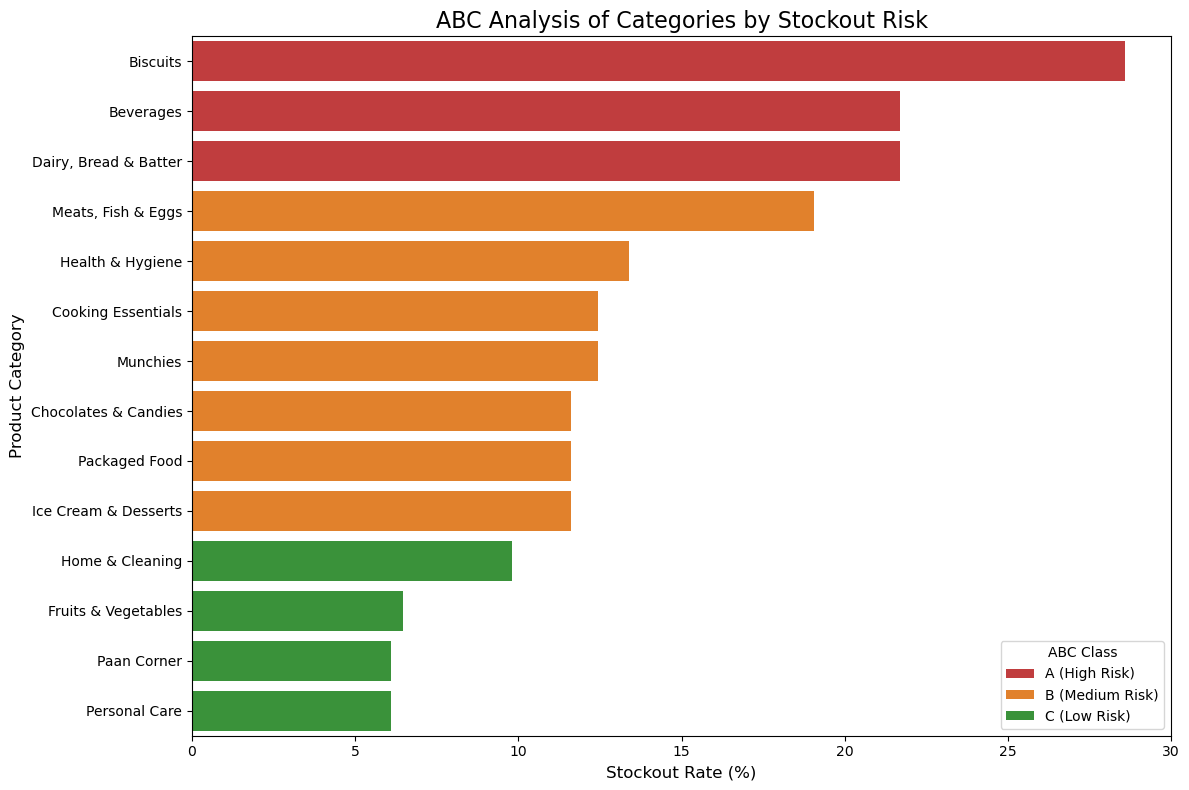

In [5]:
# --- ABC Analysis based on Stockout Rate ---
# Define the classification function
def assign_abc_class(rate):
    if rate >= 20:
        return 'A (High Risk)'
    elif 10 <= rate < 20:
        return 'B (Medium Risk)'
    else:
        return 'C (Low Risk)'

# Calculate the stockout rate
stockout_rate_by_category = (df.groupby('Category')['outOfStock'].sum() / df['Category'].value_counts() * 100)

# Create the ABC DataFrame
abc_df = stockout_rate_by_category.reset_index()
abc_df.columns = ['Category', 'Stockout Rate (%)']
abc_df['ABC Class'] = abc_df['Stockout Rate (%)'].apply(assign_abc_class)

# --- Visualization: ABC Classification ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Stockout Rate (%)', y='Category', hue='ABC Class', data=abc_df.sort_values('Stockout Rate (%)', ascending=False), dodge=False, palette={'A (High Risk)':'#d62728', 'B (Medium Risk)':'#ff7f0e', 'C (Low Risk)':'#2ca02c'})
plt.title('ABC Analysis of Categories by Stockout Risk', fontsize=16)
plt.xlabel('Stockout Rate (%)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.legend(title='ABC Class')
plt.tight_layout()
plt.show()

The ABC Analysis formally confirms that the inventory risk is highly concentrated. Categories like **Biscuits**, **Beverages**, and **Dairy, Bread & Batter** are classified as **'Class A'**, meaning they have the highest risk and require the most urgent attention.

***
## 5. Deeper Analysis: Pricing Strategy
A key question is whether promotions are driving stockouts. To investigate this, we'll look at the relationship between price, discounts, and availability at a category-specific level.

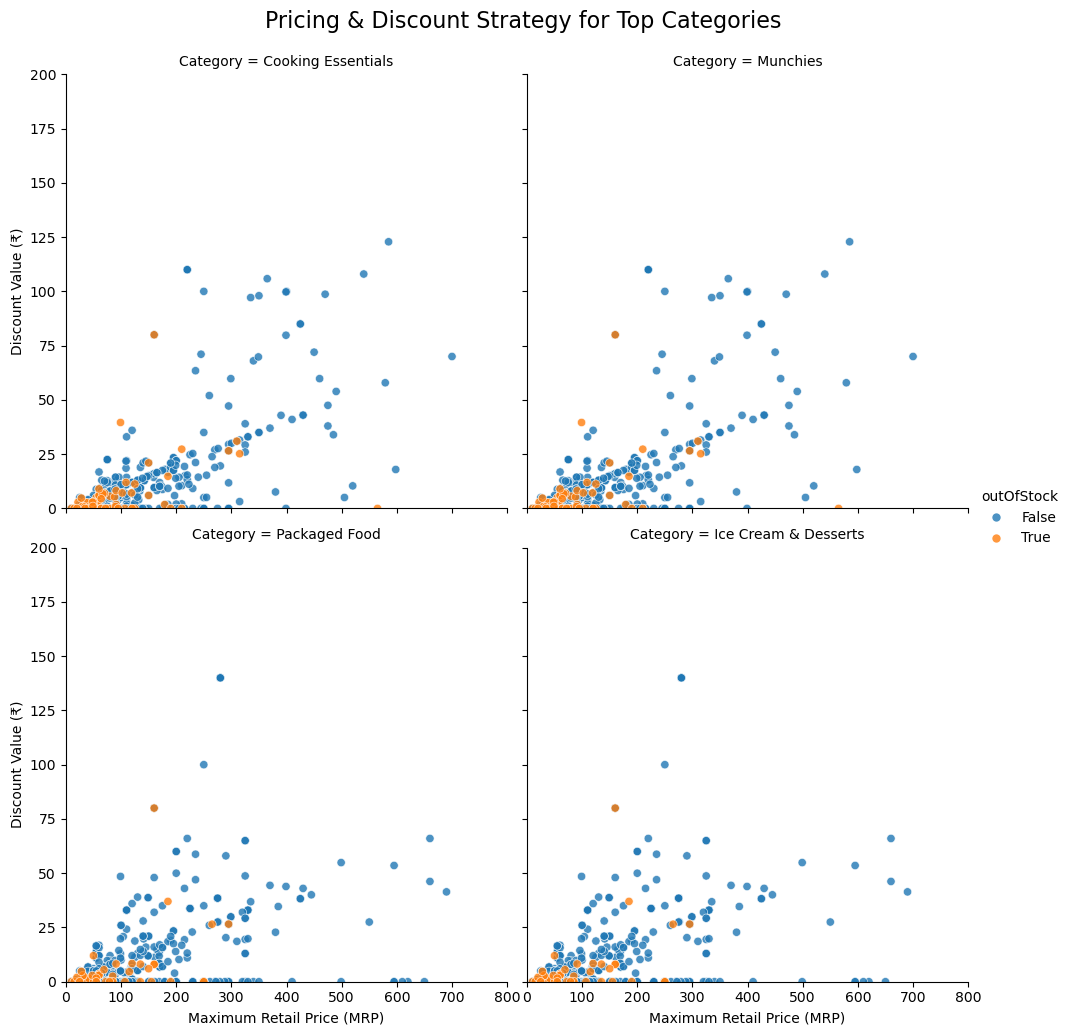

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

# Your plotting code
df['discount_value'] = df['mrp'] * (df['discountPercent'] / 100)

top_categories = df['Category'].value_counts().nlargest(4).index

g = sns.relplot(
    data=df[df['Category'].isin(top_categories)],
    x='mrp',
    y='discount_value',
    col='Category',
    hue='outOfStock',
    col_wrap=2,
    alpha=0.8
)
g.fig.suptitle('Pricing & Discount Strategy for Top Categories', fontsize=16, y=1.03)
g.set_axis_labels("Maximum Retail Price (MRP)", "Discount Value (₹)")
plt.xlim(0, 800)
plt.ylim(0, 200)
plt.show()


This analysis provides a crucial insight: in all top categories, stockouts (the **orange dots**) are almost exclusively happening to **low-MRP, low-discount-value** items. This strongly suggests that stockouts are a result of failing to meet organic demand for essentials, not a result of heavy promotions.

***
## 6. Interpretation and Recommendations

### Interpretation of Findings
The analysis shows that Zepto's inventory challenges are concentrated in managing high-demand, essential packaged goods. The **ABC Analysis** formally classifies these as 'Class A' risks. This problem is likely caused by a uniform inventory policy that is ill-suited for these fast-moving items, and may be exacerbated by the **"bullwhip effect"** in the supply chain. The root cause is a replenishment issue, not a pricing or promotions issue.

### Actionable Recommendations
Based on the analysis, I propose the following data-driven recommendations:

1.  **Adopt an ABC-Driven Inventory Policy:** Zepto should move from a uniform policy to a tiered strategy.
    * **Class A items:** Require tight control, higher safety stock, and daily monitoring.
    * **Class B items:** Require standard monitoring.
    * **Class C items:** Can use a leaner model to reduce costs.

2.  **Refine Demand Forecasting for High-Risk Goods:** Zepto should build more accurate, SKU-specific forecasting models for all Class A and critical Class B items to better predict demand and mitigate the bullwhip effect.

3.  **Introduce Priority-Based Replenishment Alerts:** An automated alert system, prioritized by the ABC framework, should be implemented to trigger immediate replenishment actions for Class A items when stock is low.

4.  **Strategically Review Pricing on High-Demand Staples:** Since the data shows these items have strong demand regardless of discounts, Zepto could test a marginal price increase (e.g., 1-3%) and reinvest the additional revenue into strengthening their supply chain.

***
## 7. Conclusion
This project successfully transformed a public dataset into a strategic action plan. By applying a structured analytical approach, we identified the root cause of Zepto's inventory issues and developed a set of targeted, data-driven recommendations to improve operational efficiency and profitability.